### Deep Ensembles
### Playing with house prices


In this notebook we explore the estimation of both aleatoric and epistemic uncertainty through Deep Ensembles. A simple perceptron is used to model the regression problem which outputs the price prediction. The same dataset from the Direct Modelling experiment is used in order to allow for the comparison of the achieved estimation of aleatoric uncertainty.

![house prices](datasets/real_estate/house_prices.png)

The decomposition of uncertainty is carried out through the application of the following entropy-based formulas:

$$ \text{Total Uncertainty (TU)} = \mathcal{H} [p(y_i | x_i, D)] = \mathcal{H} [\mathbb{E}_{p(\theta | D)} [p(y_i | x_i, \theta)] $$


$$ \text{Aleatoric Uncertainty (AU)} = \mathbb{E}_{p(\theta | D)} [\mathcal{H} [p(y_i | x_i, \theta)]] $$
$$ \text{Epistemic Uncertainty (EU)} = \text{TU} - \text{AU} $$

In [1]:
import tqdm
import math
import torch
import pandas as pd

In [2]:
import numpy as np
import seaborn as sns
from time import sleep
from pathlib import Path

from torch import nn
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# Paths, global vars
dt_folder = Path("./datasets")
dt_name = 'real_estate'

In [4]:
# Checks
assert dt_folder.exists()
assert dt_folder.is_dir()
assert (dt_folder / dt_name / (dt_name + '.csv')).exists()

#### Load Dataset

In [5]:
df = pd.read_csv(dt_folder / dt_name / (dt_name + '.csv'))

In [6]:
df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [7]:
df.dtypes

No                                          int64
X1 transaction date                       float64
X2 house age                              float64
X3 distance to the nearest MRT station    float64
X4 number of convenience stores             int64
X5 latitude                               float64
X6 longitude                              float64
Y house price of unit area                float64
dtype: object

#### Prepare data

In [8]:
train, test = train_test_split(df, test_size=0.2)

In [9]:
class HouseDataset(torch.utils.data.Dataset):
    def __init__(self, df, scale=False):
        x = df.iloc[:, 1:7]
        y = df.iloc[:, 7]
        if scale:
            x = StandardScaler().fit_transform(x)
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y.values)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

#### Model

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        return self.layers(x)        

#### Train Loop

In [235]:
epochs = 200
batch_size = 64
num_models = 5

In [236]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [237]:
# Adapted loss for direct modelling of aleatoric uncertainties
# From NLL with Gaussian noise
def ps_loss(output, target):
    # output: pred, var
    pred = output[:, 0]
    log_var = output[:, 1]
    var = torch.exp(0.5 * log_var) + 1e-5
    
    left = (1 / (2 * var ** 2)) * torch.abs(target - pred) ** 2
    right = (1 / 2) * torch.log(var ** 2)
    
    return torch.mean(left + right)

In [238]:
torch.manual_seed(42)

mean_batch_ensemble_loss = []
mean_batch_loss = np.array([])

dt_train = HouseDataset(train, scale=True)
train_loader = torch.utils.data.DataLoader(dt_train, batch_size=batch_size, num_workers=2)

models = [MLP().to(device) for _ in range(num_models)]
optimizers = [torch.optim.Adam(mlp.parameters(), lr=1e-3) for mlp in models]

# Train each ensemble model with the same data
[mlp.train() for mlp in models]

[MLP(
   (layers): Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=128, bias=True)
     (3): ReLU()
     (4): Linear(in_features=128, out_features=64, bias=True)
     (5): ReLU()
     (6): Linear(in_features=64, out_features=32, bias=True)
     (7): ReLU()
     (8): Linear(in_features=32, out_features=2, bias=True)
   )
 ),
 MLP(
   (layers): Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=128, bias=True)
     (3): ReLU()
     (4): Linear(in_features=128, out_features=64, bias=True)
     (5): ReLU()
     (6): Linear(in_features=64, out_features=32, bias=True)
     (7): ReLU()
     (8): Linear(in_features=32, out_features=2, bias=True)
   )
 ),
 MLP(
   (layers): Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=128, bias=True)
    

In [239]:
# We will be using vmap in order to optimise the ensemble training
from functorch import combine_state_for_ensemble

fmodel, params, buffers = combine_state_for_ensemble(models)
[p.requires_grad_() for p in params];

In [240]:
from functorch import vmap

for epoch in range(epochs):
    tepoch = tqdm.tqdm(train_loader)
    tepoch.set_description(f"Epoch {epoch}")
    
    # For simplification purposes, we are not shuffling input samples
    for i, obj in enumerate(tepoch):
        data, target = obj

        data, target = data.to(device), target.to(device)
        [optimizer.zero_grad() for optimizer in optimizers]
        
        # Getting the outputs from all ensembles
        outputs = [mlp(data) for mlp in models]
        outputs = [torch.squeeze(out) for out in outputs]
        
        # calculate loss per model
        out_losses = [ps_loss(output, target) for output in outputs]
        mean_batch_ensemble_loss.append([l.item() for l in out_losses])

        [out_loss.backward() for out_loss in out_losses]
        [optimizer.step() for optimizer in optimizers]

        tepoch.set_postfix(loss=sum(out_losses) / len(out_losses))
        sleep(0.1)

Epoch 199: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.39it/s, loss=tensor(2.1685, device='cuda:0', grad_fn=<DivBackward0>)]


In [241]:
l = np.asarray(mean_batch_ensemble_loss)

<AxesSubplot:>

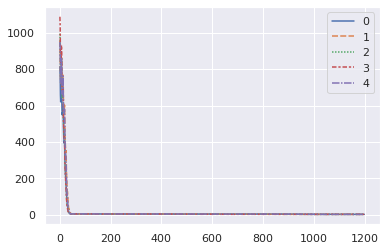

In [242]:
sns.set_theme(style="darkgrid")
sns.lineplot(data=l)

#### Testing the model

In [243]:
dt_test = HouseDataset(test, scale=True)
test_loader = torch.utils.data.DataLoader(dt_test, batch_size=batch_size, num_workers=2)

In [244]:
mean_batch_ensemble_loss_t = []
p = []
v = []

[mlp.eval() for mlp in models]
[mlp.to(device) for mlp in models]

[MLP(
   (layers): Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=128, bias=True)
     (3): ReLU()
     (4): Linear(in_features=128, out_features=64, bias=True)
     (5): ReLU()
     (6): Linear(in_features=64, out_features=32, bias=True)
     (7): ReLU()
     (8): Linear(in_features=32, out_features=2, bias=True)
   )
 ),
 MLP(
   (layers): Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=128, bias=True)
     (3): ReLU()
     (4): Linear(in_features=128, out_features=64, bias=True)
     (5): ReLU()
     (6): Linear(in_features=64, out_features=32, bias=True)
     (7): ReLU()
     (8): Linear(in_features=32, out_features=2, bias=True)
   )
 ),
 MLP(
   (layers): Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=128, bias=True)
    

In [245]:
with torch.no_grad():
    for i, obj in enumerate(test_loader):
        data, target = obj
        data, target = data.to(device), target.to(device)

        # outputs -> (num_models, batch_size, 2)
        outputs = [mlp(data) for mlp in models]
        
        out_losses = [ps_loss(output, target) for output in outputs]
        mean_batch_ensemble_loss_t.append([l.item() for l in out_losses])

        # output -> (batch_size, 2)
        p.append([output[:, 0].cpu().detach().numpy() for output in outputs])
        v.append([torch.exp(0.5 * output[:, 1]).cpu().detach().numpy() for output in outputs])
        # p -> (num_batches, batch_size, num_models)

#### Uncertainty Quantification

Each ensembled model outputs its own $\mu$ and $\sigma$ that are the moments of a Gaussian distribution. We will treat our final predictive distribution as an equally-weighted mixture of Gaussians.

$$ p(y | x) = M^{-1} \sum_{m=1}^M p_{\theta_m} (y | x, \theta_m) $$

We approximate the final predictive distribution as a Gaussian distribution with its mean and variance equal to the mixture model's moments.

$$ \mu_*(x) = M^{-1} \sum_{m=1}^M \mu_{\theta_m}(x) $$

$$ \sigma^2_*(x) = M^{-1} \sum_{m=1}^M (\sigma^2_{\theta_m} (x) + \mu_{\theta_m} (x)) - \mu^2_* (x) $$

In [246]:
mean = [np.append(p[0][i][:], p[1][i][:]) for i in range(0, num_models)]
mean = np.array(mean)
mean.shape

(5, 83)

In [247]:
var = [np.append(v[0][i][:], v[1][i][:]) for i in range(0, num_models)]
var = np.array(var)
var.shape

(5, 83)

In [249]:
#A Gaussian at each point
def approx_mixture_gaussian(mean, var):
    mean_s = (1 / num_models) * np.sum(mean, axis=0)
    var_s = (1 / num_models) * np.sum((var ** 2 + mean ** 2), axis=0) - (mean_s ** 2)
    
    return mean_s, var_s

In [250]:
mixture_mean, mixture_var = approx_mixture_gaussian(mean, var)
mixture_mean.shape, mixture_var.shape

((83,), (83,))

In [251]:
plot_df = test.copy()
plot_df['pred'] = mixture_mean
plot_df['var'] = np.sqrt(mixture_var)
plot_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,pred,var
353,354,2013.500,4.1,2147.3760,3,24.96299,121.51284,31.3,30.820250,6.206887
105,106,2012.833,0.0,292.9978,6,24.97744,121.54458,71.0,52.839912,6.684579
131,132,2013.500,4.0,2147.3760,3,24.96299,121.51284,30.7,30.873800,6.212834
239,240,2013.500,18.1,837.7233,0,24.96334,121.54767,29.7,32.079357,5.322016
118,119,2013.500,25.3,1583.7220,3,24.96622,121.51709,30.6,28.022139,6.928238
...,...,...,...,...,...,...,...,...,...,...
390,391,2013.500,32.8,377.8302,9,24.97151,121.54350,38.6,48.670559,9.364825
69,70,2012.833,12.5,561.9845,5,24.98746,121.54391,42.0,47.716198,6.462388
58,59,2013.500,30.3,4510.3590,1,24.94925,121.49542,22.6,18.189320,3.744503
197,198,2013.250,34.4,126.7286,8,24.96881,121.54089,48.2,45.615566,10.230367


In [252]:
plot_df['upper'] = plot_df['pred'] + plot_df['var']
plot_df['lower'] = plot_df['pred'] - plot_df['var']

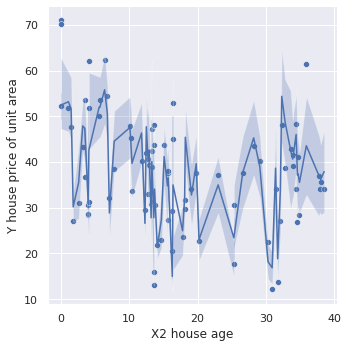

In [253]:
plot_df = plot_df.sort_values(by=['X2 house age'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df, x="X2 house age", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df, x="X2 house age", y="pred")
ax.fill_between(plot_df['X2 house age'], plot_df['lower'], plot_df['upper'], alpha=0.25)

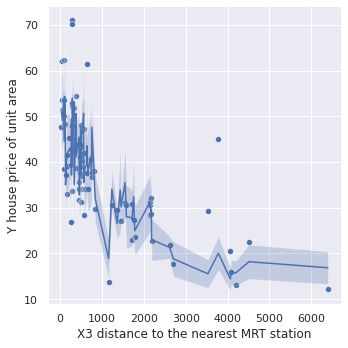

In [254]:
plot_df = plot_df.sort_values(by=['X3 distance to the nearest MRT station'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df, x="X3 distance to the nearest MRT station", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df, x="X3 distance to the nearest MRT station", y="pred")
ax.fill_between(plot_df['X3 distance to the nearest MRT station'], plot_df['lower'], plot_df['upper'], alpha=0.25)

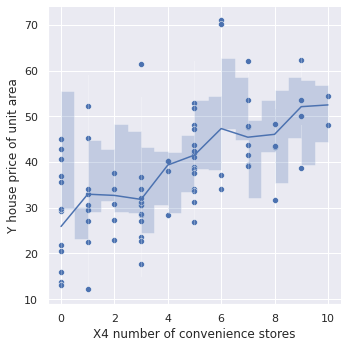

In [255]:
plot_df = plot_df.sort_values(by=['X4 number of convenience stores'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df, x="X4 number of convenience stores", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df, x="X4 number of convenience stores", y="pred", errorbar=None)
ax.fill_between(plot_df['X4 number of convenience stores'], plot_df['lower'], plot_df['upper'], alpha=0.25, step='mid')